

> 세션 저장소에 데이터를 업로드한다.



###전처리

In [15]:
import pandas as pd

f = None     # 입력 파일
inArr = []   # 데이터 리스트
df = None    # 데이터프레임

## 파일 읽어오기
f = open("Data.txt", "r")

while True:
    line = f.readline()   # 한 행씩, 모든 행 데이터 읽기
    if not line:
        break

    inArr = line.split()    # 문자열 분리

f.close()
print(inArr[:10])

['Zoledronate', 'ES7', 'PFSK-1', 'P32-ISH', 'MOLM-13', 'NCI-H1155', 'BC-1']


In [2]:
## 인덱스와 컬럼 리스트
index = []
unique_vals = []
for arr in inArr:          # 행
    index.append(arr[0])   # 항암제
    vals = arr[1:]         # 암세포 리스트

    for val in vals:
      if val not in unique_vals:
              unique_vals.append(val)   # 중복되지 않은 암세포 리스트

In [3]:
## 인접 행렬; 데이터프레임으로 변환 (컬럼, 인덱스 지정)
adj_matrix = pd.DataFrame(columns=unique_vals, index=index)   # [x[1:] for x in inArr]

# 정렬도 할 수 있음
# 컬럼과 같은 값에 1로 채우기
i = 0
for arr in inArr:          # 행
    idx = index[i]
    for col in adj_matrix.columns:          # 컬럼 이름
        if col in arr[1:]:
          adj_matrix.loc[idx, col] = 1
    i+=1

# 결측치를 0으로 채우기
adj_matrix.fillna(0, inplace=True)

adj_matrix.head()

,MOLT-16,SR,RF-48,SU-DHL-8,JURL-MK1,TC-YIK,MM1S,SJRH30,CAL-29,SK-N-DZ,...,VIII,(G12C),Inhibitor-12,acid,(-),Mesylate,bromide,A,37,IX
123138,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
123829,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
150412,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5-Fluorouracil,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5-azacytidine,1,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(adj_matrix.info())

<class 'pandas.core.frame.DataFrame'>
Index: 258 entries, 123138 to Zoledronate
Columns: 982 entries, MOLT-16 to IX
dtypes: int64(982)
memory usage: 1.9+ MB
None




> 258개의 항암제, 982개의 암세포



#1. 추천 알고리즘

## 1) 사용자 기반 협업 필터링(User-based Collaborative Filtering)

*   1번 항암제(123138)와 가장 유사한 항암제 추천


In [5]:
import numpy as np

adj_arr = adj_matrix.values                               # 인접 행렬에서 컬럼과 인덱스를 제외하고 값만 추출한 배열
first_anticancer_drug, first_cancer_list = 0, adj_arr[0]
best_match, best_match_drug, best_match_cancer = -1, -1, []

## 1번 항암제와 유사도가 가장 높은 항암제 찾기
for drug_idx, cancer_list in enumerate(adj_arr):
  if first_anticancer_drug != drug_idx:                   # 1번 항암제가 아닌 항암제
    similarity = np.dot(first_cancer_list, cancer_list)   # 각 자리를 곱하여 더함 - 치료할 수 있는 암이 얼마나 겹치는지
    if similarity > best_match:                           # 가장 높은 유사도
      best_match = similarity                             # 겹치는 암의 개수
      best_match_drug = drug_idx                          # 항암제 번호
      best_match_cancer = cancer_list

print('Best Match: {}, Best Match Drug: {}'.format(best_match, adj_matrix.iloc[[best_match_drug]].index))
adj_matrix.iloc[[first_anticancer_drug, best_match_drug]]

Best Match: 31, Best Match Drug: Index(['CDK9_5038'], dtype='object')


,MOLT-16,SR,RF-48,SU-DHL-8,JURL-MK1,TC-YIK,MM1S,SJRH30,CAL-29,SK-N-DZ,...,VIII,(G12C),Inhibitor-12,acid,(-),Mesylate,bromide,A,37,IX
123138,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
CDK9_5038,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


> 1번 항암제 '123138'과 유사도가 높은 **'CDK9_5038'** 항암제 (유사도 : 31/982)

In [6]:
recommend_list = []
## Best Match Drug에 있지만 1번 항암제 리스트에는 없는 암세포
for i, log in enumerate(zip(first_cancer_list, best_match_cancer)):
  log1, log2 = log              # log1: 1번 항암제의 암, log2: 유사도 가장 높은 항암제의 암
  if log1 < 1. and log2 > 0.:   # 유사도 가장 높은 항암제 리스트에는 있지만 1번 항암제에는 없는 암
    recommend_list.append(i)

recommend_list = adj_matrix.iloc[[best_match_drug], recommend_list].columns.tolist()   # 추천 암세포 리스트화
print('Recommandation: {}'.format(recommend_list))
print('Recommandation length: {}'.format(len(recommend_list)))   # 추천 개수

Recommandation: ['OACp4C', 'PA-1', 'LS-513', 'CAL-85-1', 'DoTc2-4510', 'NCI-H1876', 'SHP-77', 'HDQ-P1', 'TC-71', 'DEL', 'EC-GI-10', '42-MG-BA', 'SNU-423', 'WM-115', 'H4', 'NCI-H2085', 'NCI-H2023', 'JSC-1', 'Detroit562', 'MIA-PaCa-2', 'BPH-1', 'FADU', 'EW-22', 'WM1552C', 'DMS-79', 'LAMA-84', 'LoVo', 'NUGC-3', 'ESS-1', 'OCI-AML2', 'RXF393', 'Hs-578-T', 'SW620', 'AM-38', 'EB-3', 'SK-ES-1', 'CAL-54', 'CAL-120', 'LCLC-97TM1', 'NCI-H2461', 'M059J', 'AMO-1', 'CAL-51', 'NCI-H1993', 'NCI-H650', 'GP5d', 'Hep3B2-1-7', 'IGR-37', 'NY', 'NCI-H211', 'HCC2998', 'MEG-01', 'DG-75', '647-V', 'OE33', 'NCI-H596', 'BHT-101', 'A2058', 'ES5', 'EoL-1-cell', 'NCI-H446', 'TUR', '639-V', 'A4-Fuk', 'NEC8', 'KYSE-180', 'NCI-H1975', 'C-4-I', 'OVCAR-8', 'KYSE-450', 'MDA-MB-468', '786-0', 'ACHN', 'CAL-72', 'CAL-39', 'EVSA-T', 'NCI-H1944', 'ASH-3', 'MDA-MB-453', 'EPLC-272H', 'ONS-76', 'HCC-78', 'TE-5', 'AGS', 'EMC-BAC-2', 'CHP-212', 'COLO-792', 'KU812', 'T98G', 'RL95-2', 'Hs-746T', 'NOMO-1', 'L-363', 'GR-ST', 'SK-HEP-1

> '123138' 항암제에 **650개**의 암세포 추천



## 2) 컨텐츠 기반 필터링(Content-based Filtering)

*   **유클리드 거리**
*   **코사인 유사도**
*   유사도 도식화, 시각화











###2-1) **유클리드 거리**를 사용해 추천
$$euclidean = \sqrt{\sum_{d=1}^{D}(A_i - B_i)^2}$$
* 거리가 가까울 수록(**값이 작을 수록) 1번과 유사한 항암제**

In [7]:
first_anticancer_drug, first_cancer_list = 0, adj_arr[0]
best_match, best_match_drug, best_match_cancer = 9999, -1, []

## 1번 항암제와 유사도가 가장 높은 항암제 찾기
for drug_idx, cancer_list in enumerate(adj_arr):
  if first_anticancer_drug != drug_idx:                                            # 1번 항암제가 아닌 항암제
    euclidean_dist = np.sqrt(np.sum(np.square(first_cancer_list - cancer_list)))   # 유클리드 거리 계산
    if euclidean_dist < best_match:                                                # 값이 가장 작은(거리가 가장 가까운) 항암제
      best_match = euclidean_dist
      best_match_drug = drug_idx                                                   # 항암제 번호
      best_match_cancer = cancer_list                                              # 암세포 리스트

print('Best Match: {}, Best Match Drug: {}'.format(best_match, adj_matrix.iloc[[best_match_drug]].index))
adj_matrix.iloc[[first_anticancer_drug, best_match_drug]]

Best Match: 5.477225575051661, Best Match Drug: Index(['776928'], dtype='object')


,MOLT-16,SR,RF-48,SU-DHL-8,JURL-MK1,TC-YIK,MM1S,SJRH30,CAL-29,SK-N-DZ,...,VIII,(G12C),Inhibitor-12,acid,(-),Mesylate,bromide,A,37,IX
123138,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
776928,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



> 1번과 가장 유사한(유클리드 거리가 가까운) 항암제는 **'776928'**  (유클리드 거리 약 5.48)




In [8]:
euclidean_recommend_list = []
## Best Match Drug에 있지만 1번 항암제 리스트에는 없는 암세포
for i, log in enumerate(zip(first_cancer_list, best_match_cancer)):
  log1, log2 = log              # log1: 1번 항암제의 암, log2: 가장 유사한 항암제의 암
  if log1 < 1. and log2 > 0.:   # 가장 유사한 항암제 리스트에는 있지만 1번 항암제에는 없는 암
    euclidean_recommend_list.append(i)

print(euclidean_recommend_list)

[]


> 유클리드 거리는 가장 가깝지만 **중복되는 암세포가 없어서** 추천 리스트가 추출되지 않음 → **부적합**



###2-2) **코사인 유사도**를 사용해 추천

\begin{equation}
cos \theta = \frac{A \cdot B}{||A|| \times ||B||}
\end{equation}
* 두 벡터가 이루고 있는 각을 계산

In [9]:
def compute_cos_similarity(v1, v2):
  norm1 = np.sqrt(np.sum(np.square(v1)))
  norm2 = np.sqrt(np.sum(np.square(v2)))
  dot = np.dot(v1, v2)
  return dot/(norm1 * norm2)

In [10]:
first_anti_cancer_drug, first_cancer_list = 0, adj_arr[0]
best_match, best_match_drug, best_match_cancer = -1, -1, []

## 1번 항암제와 가장 유사한 항암제 찾기
for drug_idx, cancer_list in enumerate(adj_arr):
  if first_anti_cancer_drug != drug_idx:                                       # 1번 항암제가 아닌 항암제
    cos_similarity = compute_cos_similarity(first_cancer_list, cancer_list)   # 코사인 유사도 계산
    if cos_similarity > best_match:
      best_match = cos_similarity
      best_match_drug = drug_idx
      best_match_cancer = cancer_list

print('Best Match: {}, Best Match Drug: {}'.format(best_match, adj_matrix.iloc[[best_match_drug]].index))
adj_matrix.iloc[[first_anti_cancer_drug, best_match_drug]]

Best Match: 0.3457170297823857, Best Match Drug: Index(['Gallibiscoquinazole'], dtype='object')


,MOLT-16,SR,RF-48,SU-DHL-8,JURL-MK1,TC-YIK,MM1S,SJRH30,CAL-29,SK-N-DZ,...,VIII,(G12C),Inhibitor-12,acid,(-),Mesylate,bromide,A,37,IX
123138,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Gallibiscoquinazole,1,1,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0




> 1번과 가장 유사한(코사인 유사도가 높은) 항암제는 **'Gallibiscoquinazole'**  (각도 약 0.35)




In [11]:
cos_recommend_list = []
## Best Match Drug에 있지만 1번 항암제 리스트에는 없는 암세포
for i, log in enumerate(zip(first_cancer_list, best_match_cancer)):
  log1, log2 = log
  if log1 < 1. and log2 > 0.:
    cos_recommend_list.append(i)

cos_recommend_list = adj_matrix.iloc[[best_match_drug], cos_recommend_list].columns.tolist()   # 추천 암세포 리스트화
print('Recommandation: {}'.format(cos_recommend_list))
print('Recommandation length: {}'.format(len(cos_recommend_list)))   # 추천 개수

Recommandation: ['NCI-H1876', 'H4', 'OCI-AML2', 'AM-38', 'SK-ES-1', '647-V', 'EoL-1-cell', 'NEC8', 'KYSE-180', 'EVSA-T', 'KU812', 'SKM-1', 'RPMI-8866', 'ES8', 'HTC-C3', 'CPC-N', 'KASUMI-1', 'BFTC-905', 'ALL-SIL', 'H9', 'BE-13', 'SCC-3', 'IMR-5', 'SUP-M2', 'ATN-1', 'JiyoyeP-2003', 'KELLY', 'SU-DHL-10', 'VAL', 'ARH-77', 'DB', 'SUP-B15', 'Ramos-2G6-4C10', 'CCRF-CEM', 'NCI-H1155', 'RS4-11', 'MRK-nu-1', 'RH-41', 'TK', 'RH-1', 'HCC1954', 'LK-2', 'SBC-5', 'LP-1', 'DND-41', 'MS-1', 'CADO-ES1', 'SK-MG-1', 'CAMA-1', 'NCI-H250', 'NCI-H716', 'NCI-H1048', 'ES-2', 'DMS-53', 'NCI-H520', 'NCI-H209', 'REH', 'NCI-H2795', 'A427', 'T84', 'LN-18']
Recommandation length: 61




> **61개**의 암세포 추천




###2-3) **유사도 도식화**


In [12]:
## 코사인 유사도 도식화, 시각화
from sklearn.metrics.pairwise import cosine_similarity

# 데이터프레임 형태의 유사도 계산
df_similarity = pd.DataFrame(cosine_similarity(adj_matrix, adj_matrix))

for n in range(len(df_similarity)):
  df_similarity.iloc[n][n] = 0

df_similarity

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,257
0,0.000000,0.122490,0.142736,0.078594,0.221616,0.187418,0.217007,0.224155,0.000000,0.188468,...,0.208297,0.053882,0.000000,0.087121,0.199909,0.000000,0.000000,0.165844,0.181179,0.146647
1,0.122490,0.000000,0.307130,0.149219,0.304241,0.396496,0.523250,0.481231,0.039375,0.342488,...,0.407189,0.150039,0.051554,0.132326,0.386147,0.039375,0.000000,0.370847,0.315658,0.083527
2,0.142736,0.307130,0.000000,0.173883,0.213722,0.375154,0.336075,0.298824,0.152944,0.268050,...,0.238953,0.119208,0.000000,0.289122,0.256394,0.076472,0.000000,0.231020,0.227930,0.162221
3,0.078594,0.149219,0.173883,0.000000,0.276898,0.282675,0.237925,0.203051,0.000000,0.098397,...,0.281945,0.087519,0.000000,0.176887,0.317651,0.000000,0.000000,0.336722,0.302942,0.059549
4,0.221616,0.304241,0.213722,0.276898,0.000000,0.459849,0.441524,0.387269,0.000000,0.213427,...,0.395467,0.189832,0.035875,0.184164,0.399617,0.000000,0.000000,0.438217,0.433681,0.116248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,0.000000,0.039375,0.076472,0.000000,0.000000,0.043033,0.034879,0.027714,0.333333,0.043274,...,0.074398,0.000000,0.000000,0.140028,0.083820,0.000000,0.000000,0.088852,0.102778,0.000000
254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.085907,0.000000,0.188982,0.000000,0.096787,0.000000,0.000000,0.102598,0.089009,0.000000
255,0.165844,0.370847,0.231020,0.336722,0.438217,0.577363,0.536141,0.517110,0.059235,0.280686,...,0.716130,0.277014,0.077557,0.199069,0.719933,0.088852,0.102598,0.000000,0.678819,0.104713
256,0.181179,0.315658,0.227930,0.302942,0.433681,0.482093,0.440931,0.432952,0.068519,0.271307,...,0.627013,0.296695,0.044856,0.143918,0.608783,0.102778,0.089009,0.678819,0.000000,0.121125




> **유사도 시각화**



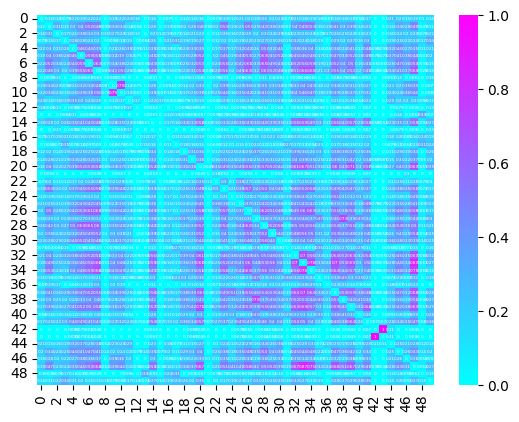

In [13]:
## 50x50 히트맵
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(df_similarity.iloc[0:50,0:50], annot=True, annot_kws={'color': 'w', 'fontsize': 3}, cmap='cool')
plt.show()